In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [135]:
df = pd.read_csv("rounds_after_course_elim.csv")
df.columns

Index(['tour', 'year', 'season', 'event_completed', 'event_name', 'event_id',
       'player_name', 'dg_id', 'fin_text', 'round_num', 'course_name',
       'course_num', 'start_hole', 'teetime', 'round_score', 'sg_putt',
       'sg_arg', 'sg_app', 'sg_ott', 'driving_dist', 'driving_acc', 'gir',
       'scrambling', 'prox_rgh', 'prox_fw', 'eagles_or_better', 'birdies',
       'pars', 'bogies', 'doubles_or_worse', 'calendar_year', 'date',
       'sg_categories', 'traditional_stats', 'par', 'yardage_4_5', 'yardage_3',
       'adj_par_3_score', 'adj_par_4_score', 'adj_par_5_score',
       'adj_driving_distance', 'adj_sd_distance', 'adj_driving_accuracy',
       'ott_sg', 'fw_width', 'fw_diff', 'rgh_diff', 'non_rgh_diff',
       'miss_fw_pen_frac', 'adj_gir', 'less_150_sg', 'greater_150_sg',
       'adj_penalties', 'adj_ob', 'arg_fairway_sg', 'arg_rough_sg',
       'arg_bunker_sg', 'less_5_ft_sg', 'greater_5_less_15_sg',
       'greater_15_sg', 'course', 'country'],
      dtype='object')

In [136]:
dropped_cols = df.iloc[:, 30:].columns
df = df.drop(columns=dropped_cols)

In [137]:
df.columns

Index(['tour', 'year', 'season', 'event_completed', 'event_name', 'event_id',
       'player_name', 'dg_id', 'fin_text', 'round_num', 'course_name',
       'course_num', 'start_hole', 'teetime', 'round_score', 'sg_putt',
       'sg_arg', 'sg_app', 'sg_ott', 'driving_dist', 'driving_acc', 'gir',
       'scrambling', 'prox_rgh', 'prox_fw', 'eagles_or_better', 'birdies',
       'pars', 'bogies', 'doubles_or_worse'],
      dtype='object')

In [138]:
dropped_cols = ['tour', 'event_completed', 'event_name', 'event_id', 'round_num', 'teetime', 'start_hole', 'course_num', 'birdies', 'bogies', 'doubles_or_worse', 'round_score', 'pars', 'eagles_or_better']
df = df.drop(columns=dropped_cols)


dropped_cols = [col for col in df.columns if col.startswith('sg_')]

df2 = df.drop(columns=dropped_cols)

In [139]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15858 entries, 0 to 15857
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          15858 non-null  int64  
 1   season        15858 non-null  int64  
 2   player_name   15858 non-null  object 
 3   dg_id         15858 non-null  int64  
 4   fin_text      15858 non-null  object 
 5   course_name   15858 non-null  object 
 6   driving_dist  15726 non-null  float64
 7   driving_acc   15726 non-null  float64
 8   gir           15726 non-null  float64
 9   scrambling    15724 non-null  float64
 10  prox_rgh      15200 non-null  float64
 11  prox_fw       15726 non-null  float64
dtypes: float64(6), int64(3), object(3)
memory usage: 1.5+ MB


In [140]:
avg = df2.groupby(["season", "dg_id"]).mean(numeric_only=True).reset_index()

avg.head()

,season,dg_id,year,driving_dist,driving_acc,gir,scrambling,prox_rgh,prox_fw
0,2024,44,2024.0,271.950,0.85700,0.33350,0.5225,71.09800,53.17800
1,2024,612,2024.0,272.300,0.82150,0.47200,0.5165,70.77700,42.37950
2,2024,653,2024.0,288.575,0.73225,0.61125,0.4205,62.34875,38.26075
3,2024,863,2024.0,249.600,0.53550,0.30550,0.4725,72.58700,39.96400
4,2024,874,2024.0,258.600,0.57100,0.38900,0.3570,122.00000,57.45000


In [141]:
avg.drop(columns=["year"], inplace=True)

In [142]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression

passthrough_cols = ['dg_id', 'season']
X = avg.drop(columns=passthrough_cols)

pre = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), X.columns)
    ],
    remainder='drop'
)

pipe = Pipeline(steps=[
    ('pre', pre),
    ('pca', PCA(n_components=2, random_state=0))
])

pcs = pipe.fit_transform(avg)
pc_df = pd.DataFrame(pcs, columns=['PC1', 'PC2'], index=avg.index)

out = pd.concat([avg[passthrough_cols], pc_df], axis=1)


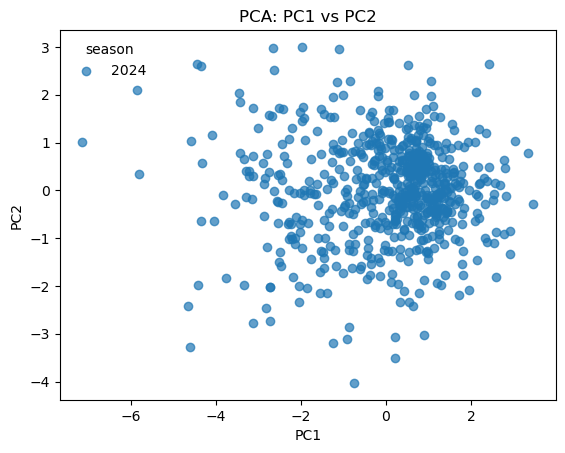

In [143]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for s, g in out.groupby('season'):
    ax.scatter(g['PC1'], g['PC2'], label=str(s), alpha=0.7)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('PCA: PC1 vs PC2')
ax.legend(title='season', frameon=False)
plt.show()

In [144]:
import numpy as np, pandas as pd

pca = pipe.named_steps['pca']
feat_cols = [c for c in avg.columns if c not in ['dg_id','season']]

# Loadings (feature contributions)
loadings = pd.DataFrame(pca.components_, 
                        columns=feat_cols, 
                        index=[f'PC{i+1}' for i in range(pca.n_components_)])
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Top |loadings| for PC1:\n", loadings.loc['PC1', :].abs().sort_values(ascending=False).head(10))
print("Top |loadings| for PC2:\n", loadings.loc['PC2', :].abs().sort_values(ascending=False).head(10))

Xz = pipe.named_steps['pre'].transform(avg)
Xz = pd.DataFrame(Xz, columns=feat_cols, index=avg.index)
scores = pd.DataFrame(pcs, columns=['PC1','PC2'], index=avg.index)

corr_pc1 = Xz.corrwith(scores['PC1']).sort_values(key=np.abs, ascending=False).head(10)
corr_pc2 = Xz.corrwith(scores['PC2']).sort_values(key=np.abs, ascending=False).head(10)
print("Strongest correlations with PC1:\n", corr_pc1)
print("Strongest correlations with PC2:\n", corr_pc2)


Explained variance ratio: [0.40050726 0.18511555]
Top |loadings| for PC1:
 gir             0.563736
prox_fw         0.512441
prox_rgh        0.396148
scrambling      0.366706
driving_dist    0.344277
driving_acc     0.098347
Name: PC1, dtype: float64
Top |loadings| for PC2:
 driving_acc     0.800878
driving_dist    0.524256
scrambling      0.238149
prox_rgh        0.134079
gir             0.088938
prox_fw         0.033900
Name: PC2, dtype: float64
Strongest correlations with PC1:
 gir             0.873890
prox_fw        -0.794374
prox_rgh       -0.614099
scrambling      0.568459
driving_dist    0.533689
driving_acc     0.152455
dtype: float64
Strongest correlations with PC2:
 driving_acc     0.844040
driving_dist   -0.552510
scrambling      0.250983
prox_rgh        0.141305
gir             0.093732
prox_fw        -0.035727
dtype: float64


In [145]:
out.head()

,dg_id,season,PC1,PC2
0,44,2024,-4.443195,2.649583
1,612,2024,-2.641805,2.520068
2,653,2024,-1.144612,0.867016
3,863,2024,-4.581898,1.031630
4,874,2024,-7.147164,1.022593


In [149]:
merged_cols = [col for col in df.columns if col.startswith('sg_')]
merged_cols = merged_cols + ['dg_id', 'season']

out = out.merge(df[merged_cols], on=['dg_id', 'season'], how='inner')

In [150]:
out.head()

,dg_id,season,PC1,PC2,sg_putt,sg_arg,sg_app,sg_ott
0,44,2024,-4.443195,2.649583,1.710,0.571,-2.115,-1.087
1,44,2024,-4.443195,2.649583,0.809,-2.960,-3.996,-0.426
2,612,2024,-2.641805,2.520068,-0.872,-0.167,-3.707,-4.923
3,612,2024,-2.641805,2.520068,-0.435,-1.441,-1.290,-0.895
4,653,2024,-1.144612,0.867016,-2.977,-0.823,2.069,0.158


In [151]:
out.to_csv('PCA_output.csv', index=False)